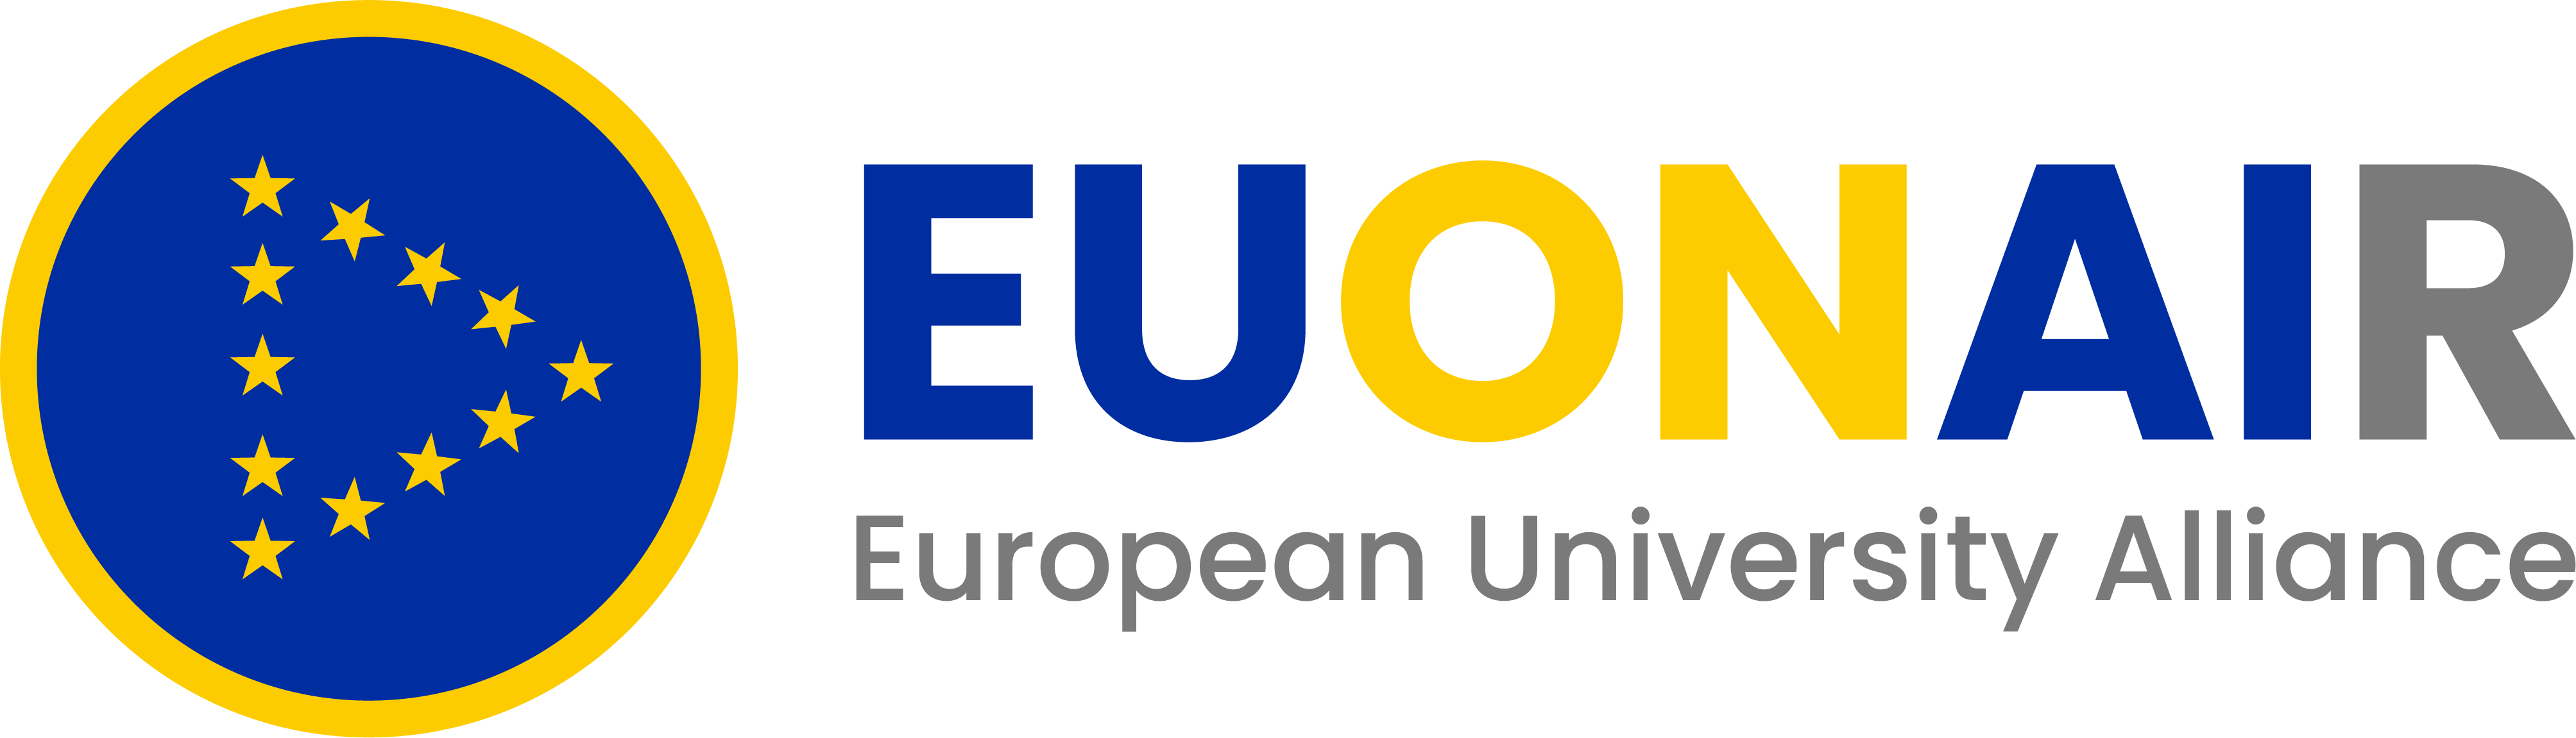

# Multi-class Classification in Machine Learning

This notebook provides a practical overview of multi-class classification, with a focus on:
- Comparing different classification algorithms (Logistic Regression, Random Forest, SVM)
- Extending binary classifiers using One-vs-Rest and One-vs-One strategies
- Evaluating performance using metrics, confusion matrices, and PCA visualizations
- Interpreting model behavior through feature importance analysis

## Outline
1. Introduction and Problem Definition  
2. Challenges in Multi-class Classification  
3. Strategies to Extend Binary Classifiers  

4. Implementation Examples  
   - 4.1 Logistic Regression (OvR & OvO)  
   - 4.2 Random Forest Classifier  
   - 4.3 Support Vector Machine (SVM)  

5. Evaluation and Visualizations  
   - 5.1 Accuracy and Confusion Matrices  
   - 5.2 PCA-based Decision Boundary Visualization  
   - 5.3 Feature Importances (Random Forest)  

6. Model Comparison and Summary  
7. Conclusion and Recommendations


## 1. Introduction and Problem Definition

In multi-class classification, our goal is to assign an input to one of three or more classes.
For this notebook, we assume that data preprocessing and feature engineering have been completed.
We will focus on model training, extending binary classifiers, and evaluating the performance.

## 2. Challenges in Multi-class Classification

- **Extending Binary Classifiers:**  
  When our base classifier only supports binary classification, we need strategies like:
  - **One-vs-Rest (OvR)**
  - **One-vs-One (OvO)**
- **Class Imbalance:**  
  Some classes may have significantly fewer samples than others.
- **Evaluation Metrics:**  
  Metrics need to capture performance across all classes.

## 3. Strategies to Extend Binary Classifiers

### One-vs-Rest (OvR)
In OvR, one classifier per class is trained to distinguish that class from all others.

### One-vs-One (OvO)
In OvO, a classifier is trained for every pair of classes.

Below, we demonstrate how to implement these strategies using scikit-learn.




### Data Loading and Setup
This cell imports necessary libraries (Pandas, NumPy, Matplotlib, Seaborn, scikit-learn) and defines a flexible `load_data()` function.


In [ ]:
# Data & Utility
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Multiclass Strategies
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

# Dataset Utilities
from sklearn.utils import Bunch
from sklearn.datasets import load_iris, load_wine, load_digits  # Optional built-in datasets

# =============================================================================
# AI TUTOR SYSTEM SETUP
# =============================================================================

import euonair_tutor

print("✅ Libraries imported successfully!")
print("📚 This notebook explores multiclass classification methods with practical examples")

In [ ]:
%ai_tutor -s setup

### Feature and Target Definition

In this cell, users can optionally define which columns should be used as features and which as target(s).
This is useful when working with custom CSV files.

If left unspecified in the loading function, the default behavior is:
- Target = last column
- Features = all other columns

This cell is intended to be filled manually as needed.

In [ ]:
%%ai_tutor -s dataset -t multiclass_classification
custom_csv_path = "../Data/Dry_Bean_Dataset.csv"
custom_feature_columns = [
   "Area", "Perimeter", "MajorAxisLength", "MinorAxisLength", "AspectRation",
   "Eccentricity", "ConvexArea", "EquivDiameter", "Extent", "Solidity",
   "roundness", "Compactness", "ShapeFactor1", "ShapeFactor2", "ShapeFactor3", "ShapeFactor4"
]
custom_target_columns = ["Class"]
sep=","
decimal="."


# custom_csv_path = "../data/iris.csv"
# custom_feature_columns = ["150", "4", "setosa", "versicolor"]
# custom_target_columns = ["virginica"]
# sep=","
# decimal="."

### Convert CSV to Scikit-Learn Dataset  
This function loads a CSV file and converts it into a **Scikit-Learn compatible format** (`Bunch` object). It automatically detects feature and target columns, supports **multi-label data**, and ensures correct array formatting for seamless model training.
    
    Converts a CSV file into a Scikit-Learn dataset, including multi-label support.
    
    Parameters:
    - path: Path to the CSV file
    - feature_columns: List with feature columns or None for all except target column
    - target_columns: List with target columns or None for the last column
    
    Return:
    - Bunch object with `.data`, `.target`, `.feature_names`, `.target_names`
    


In [ ]:
%%ai_tutor -s dataset -t multiclass_classification
def csv_to_sklearn(path, feature_columns=None, target_columns=None, sep=",", decimal="."):
    import pandas as pd
    import numpy as np
    from sklearn.utils import Bunch

    df = pd.read_csv(path, sep=sep, decimal=decimal)

    # Defaults: last field = Target, rest = Features
    if target_columns is None:
        target_columns = [df.columns[-1]]
    if feature_columns is None:
        feature_columns = [c for c in df.columns if c not in target_columns]

    # take only columns that are present
    used_features = [c for c in feature_columns if c in df.columns]
    if len(used_features) < len(feature_columns):
        missing = [c for c in feature_columns if c not in df.columns]
        print("⚠️ Ignore missing feature columns:", missing)

    X = df[used_features].copy()
    y = df[target_columns[0]].copy()

    # Missing values
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

    if num_cols:
        X[num_cols] = X[num_cols].fillna(X[num_cols].median())
    for c in cat_cols:
        if X[c].isnull().any():
            X[c] = X[c].fillna(X[c].mode().iloc[0] if not X[c].mode().empty else "")

    # Transform categorical columns in dummy columns
    if cat_cols:
        X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

    # Transform y to 1D-Array and extract class names
    y = y.values.ravel()
    class_names = [str(c) for c in pd.Series(y).unique()]

    return Bunch(
        data=X,                      # DataFrame!
        target=y,                    # 1D array
        feature_names=X.columns.tolist(),
        target_names=class_names

    )


Shows the first rows with column names

In [ ]:
%%ai_tutor -s dataset -t multiclass_classification
# Quick preview of the data
df = pd.read_csv(custom_csv_path)
print(df.head())


### Dataset Selection (Custom CSV or Scikit-Learn)
Use your own dataset via csv_to_sklearn(), or fall back to a built-in scikit-learn dataset.
Only one dataset should be active at a time.

In [ ]:
%%ai_tutor -s dataset -t multiclass_classification df
dataset = csv_to_sklearn(
    path=custom_csv_path,
    feature_columns=custom_feature_columns,
    target_columns=custom_target_columns,
    sep=sep,
    decimal=decimal
)

# dataset = load_iris()
# dataset = load_wine()
# dataset = load_digits()

### Extract Data and Class Names from Dataset
Converts the loaded dataset into pandas structures for easier processing.
Also saves the class names for later use in reports and visualizations.

In [ ]:
%%ai_tutor -s dataset -t multiclass_classification dataset
class_names = dataset.target_names
X = pd.DataFrame(dataset.data, columns=dataset.feature_names)
y = pd.Series(dataset.target)


### Train-Test-Split & Scaling
This cell splits the data into training and test sets (70%/30%) and scales the features using StandardScaler.
The scaler converts all features to have mean 0 and standard deviation 1.
This ensures all features are on the same scale, which improves model performance.


In [ ]:
%%ai_tutor -s dataset -t multiclass_classification dataset X y
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Save columns/index before scaling
columns = X_train.columns
index_train = X_train.index
index_test = X_test.index

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert back to DataFrame
X_train = pd.DataFrame(X_train, columns=columns, index=index_train)
X_test = pd.DataFrame(X_test, columns=columns, index=index_test)


# Classification Algorithms

## Helper Function: Decision Boundary Plotting
This function can be used for any classifier (e.g., OvR, OvO, SVM) and works with both numerical and string class labels.

In [ ]:
%%ai_tutor -s dataset -t multiclass_classification dataset X y
def plot_decision_boundaries(clf, X, y, title, ax):
    if isinstance(X, pd.DataFrame):
        X = X.values
    X = X.astype(float)

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    if isinstance(Z[0], str):
        Z = label_encoder.transform(Z)
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y_encoded, edgecolor='k', cmap='viridis')
    ax.set_title(title)
    legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
    ax.add_artist(legend1)


## Logistic Regression (Main Model)
Logistic Regression is a linear model used for classification. Since it naturally handles only binary problems,
we extend it to multi-class classification using two strategies:
- One-vs-Rest (OvR): One classifier per class against all others
- One-vs-One (OvO): One classifier for each pair of classes

We will train both and compare their performance using classification metrics and decision boundaries in PCA space.

In [ ]:
%%ai_tutor -s dataset -t multiclass_classification dataset X y
# Base model
base_clf = LogisticRegression(solver='lbfgs', max_iter=200)

# One-vs-Rest
ovr_clf = OneVsRestClassifier(base_clf)
ovr_clf.fit(X_train, y_train)
y_pred_ovr = ovr_clf.predict(X_test)

print("One-vs-Rest Classification Report:\n")
print(classification_report(y_test, y_pred_ovr, target_names=class_names))
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_ovr) * 100))

# One-vs-One
ovo_clf = OneVsOneClassifier(base_clf)
ovo_clf.fit(X_train, y_train)
y_pred_ovo = ovo_clf.predict(X_test)

print("One-vs-One Classification Report:\n")
print(classification_report(y_test, y_pred_ovo, target_names=class_names))
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_ovo) * 100))

# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

cm_ovr = confusion_matrix(y_test, y_pred_ovr)
cm_ovo = confusion_matrix(y_test, y_pred_ovo)

sns.heatmap(cm_ovr, annot=True, fmt='d', ax=axes[0], cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
axes[0].set_title('Confusion Matrix - OvR')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(cm_ovo, annot=True, fmt='d', ax=axes[1], cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
axes[1].set_title('Confusion Matrix - OvO')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.show()

# PCA + Decision Boundaries
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

ovr_clf_pca = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=200))
ovr_clf_pca.fit(X_train_pca, y_train)

ovo_clf_pca = OneVsOneClassifier(LogisticRegression(solver='lbfgs', max_iter=200))
ovo_clf_pca.fit(X_train_pca, y_train)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_decision_boundaries(ovr_clf_pca, X_test_pca, y_test, 'OvR Decision Boundaries', axes[0])
plot_decision_boundaries(ovo_clf_pca, X_test_pca, y_test, 'OvO Decision Boundaries', axes[1])
plt.show()


## Random Forest Classifier

Random Forest is an ensemble learning method that builds multiple decision trees and combines their outputs.
It supports multi-class classification natively and is known for robustness and good performance out-of-the-box.

Here we will train a Random Forest classifier, evaluate it with a confusion matrix,
and visualize the feature importances.

In [ ]:
%%ai_tutor -s dataset -t multiclass_classification dataset X y
# Train Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

print("Random Forest Classification Report:\n")
print(classification_report(y_test, y_pred_rf, target_names=class_names))
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_rf) * 100))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Feature Importance
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()


## Support Vector Machine (SVM)

Support Vector Machines (SVMs) are powerful classifiers that aim to find the optimal hyperplane
that separates classes with the maximum margin. Using kernel tricks (e.g., RBF), SVMs can handle
non-linear boundaries.

Here we train an SVM with an RBF kernel and evaluate its performance.
We also visualize the decision boundaries in 2D using PCA.

In [ ]:
%%ai_tutor -s dataset -t multiclass_classification dataset X y
# Train SVM with RBF kernel
svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)

print("SVM Classification Report:\n")
print(classification_report(y_test, y_pred_svm, target_names=class_names))
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_svm) * 100))

# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# PCA Decision Boundary
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

svm_clf_pca = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_clf_pca.fit(X_train_pca, y_train)

x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
h = 0.02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = svm_clf_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundaries for SVM
fig, ax = plt.subplots(figsize=(8, 6))
plot_decision_boundaries(svm_clf_pca, X_test_pca, y_test, 'SVM Decision Boundaries (PCA)', ax)
plt.show()



# Evaluation & Comparison

This section summarizes and compares the performance of all classifiers trained so far:
- Logistic Regression (OvR & OvO)
- Random Forest
- Support Vector Machine

We compare accuracy and confusion matrices to better understand
how each model performs and where its strengths and limitations lie.

In [ ]:
%%ai_tutor -s dataset -t multiclass_classification dataset X y
# Accuracy comparison
acc_ovr = accuracy_score(y_test, y_pred_ovr)
acc_ovo = accuracy_score(y_test, y_pred_ovo)
acc_rf = accuracy_score(y_test, y_pred_rf)
acc_svm = accuracy_score(y_test, y_pred_svm)

print("\n=== Accuracy Comparison ===")
print(f"Logistic Regression (OvR): {acc_ovr:.2%}")
print(f"Logistic Regression (OvO): {acc_ovo:.2%}")
print(f"Random Forest:             {acc_rf:.2%}")
print(f"SVM (RBF Kernel):          {acc_svm:.2%}")

# Plot confusion matrices side-by-side
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.heatmap(cm_ovr, annot=True, fmt='d', cmap='Blues', xticklabels=class_names,
            yticklabels=class_names, ax=axes[0, 0])
axes[0, 0].set_title('LogReg OvR')

sns.heatmap(cm_ovo, annot=True, fmt='d', cmap='Blues', xticklabels=class_names,
            yticklabels=class_names, ax=axes[0, 1])
axes[0, 1].set_title('LogReg OvO')

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=class_names,
            yticklabels=class_names, ax=axes[1, 0])
axes[1, 0].set_title('Random Forest')

sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names,
            yticklabels=class_names, ax=axes[1, 1])
axes[1, 1].set_title('SVM')

for ax in axes.flat:
    ax.set(xlabel='Predicted', ylabel='True')

plt.tight_layout()
plt.show()


## Running the Test Dataset on the trained model

This cell preprocesses the test data (encoding, reindexing, imputation),  
scales it, predicts class probabilities using the trained **Logistic Regression One-vs-Rest (OvR)** model,  
aligns class order, normalizes probabilities,  
and writes the final `submission.csv` with sanity checks.

In [ ]:
%%ai_tutor -s dataset -t multiclass_classification dataset X y

# === Submission, identical feature layout as in Fit ===
import numpy as np, pandas as pd

TEST_PATH = "../Data/test-for-mcc/test.csv"   # adapt as needed
ID_COL    = "id"
EXPECTED  = ["C", "CL", "D"]
PREFIX    = "Status_"
OUT       = "submission.csv"
EPS       = 1e-15

feature_cols  = X_train.columns
train_median  = X_train.median(numeric_only=True) 

test = pd.read_csv(TEST_PATH)
X_kaggle_raw = test.drop(columns=[ID_COL], errors="ignore")

X_kaggle = pd.get_dummies(X_kaggle_raw, drop_first=True)

X_kaggle = X_kaggle.reindex(columns=feature_cols, fill_value=0)

X_kaggle = X_kaggle.fillna(train_median).fillna(0.0)

# after Preprocessing (get_dummies, reindex, fillna)
X_kaggle_s = scaler.transform(X_kaggle)

proba = ovr_clf.predict_proba(X_kaggle_s)


model_classes = list(ovr_clf.classes_)
idx = [model_classes.index(c) for c in EXPECTED]
proba = proba[:, idx]

proba = np.clip(proba, EPS, 1-EPS)
proba = proba / proba.sum(axis=1, keepdims=True)

# 9) Write file for submission
cols = [f"{PREFIX}{c}" for c in EXPECTED]
sub = pd.DataFrame(proba, columns=cols)
sub.insert(0, ID_COL, test[ID_COL].values)
sub.to_csv(OUT, index=False)

# Sanity-Checks
print("✅ wrote", OUT, "| columns:", [ID_COL] + cols)
print("   model classes:", model_classes)
print("   X_kaggle shape:", X_kaggle.shape, "| matches train:", X_kaggle.shape[1] == len(feature_cols))
print("   any NaN in X_kaggle?", X_kaggle.isna().any().any())
print("   proba col means:", proba.mean(axis=0))

# Conclusion & Recommendations

In this notebook, we explored three popular models for multi-class classification:
- Logistic Regression (with OvR and OvO strategies)
- Random Forest Classifier
- Support Vector Machine (with RBF kernel)

Each model was evaluated using accuracy and confusion matrices,
and we visualized decision boundaries using PCA.

Key Takeaways:
- **Logistic Regression** is simple, fast, and interpretable. OvO often performed slightly better than OvR.
- **Random Forest** showed strong performance and gave us insight into feature importance.
- **SVM** offered strong accuracy with the RBF kernel, especially when the data was not linearly separable.

### Recommendations:
- For fast baseline models: use Logistic Regression (OvR).
- For interpretable and robust results: Random Forest is a great default choice.
- For high precision in more complex boundaries: SVM is a strong candidate (especially with kernel tuning).

Future improvements could include:
- Cross-validation for more robust evaluation
- Hyperparameter tuning with GridSearchCV
- Ensembling multiple models
- Application to larger or more complex datasets

## References
- Scikit-learn documentation: [https://scikit-learn.org](https://scikit-learn.org)
- Relevant research papers and articles on multi-class classification strategies.